In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sidetable as std 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from itertools import combinations 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [87]:
pip install sidetable

In [88]:
data = pd.read_csv(r"C:\Users\Asus\Desktop\Herst doc\Final project\data_banknote_authentication.txt", header=None)
data.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'auth']
data.head()

,variance,skewness,curtosis,entropy,auth
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Exploratory Data Analysis

In [89]:

# Count total records, fake notes, and genuine notes
n_records = len(data)
n_fake_notes = len(data[data['auth'] == 0])  # 0 = Fake notes
n_real_notes = len(data[data['auth'] == 1])  # 1 = Genuine notes

# Display results
print("Total number of records: {}".format(n_records))
print("Total number of fake notes: {}".format(n_fake_notes))
print("Total number of real notes: {}".format(n_real_notes))

# Check for missing values
missing_values = data.isnull().sum().sum()
if missing_values == 0:
    print("\nThere are no missing values in the dataset")
else:
    print("\nThe dataset has {} missing values".format(missing_values))

Total number of records: 1372
Total number of fake notes: 762
Total number of real notes: 610

There are no missing values in the dataset


In [90]:
display(data.describe())

,variance,skewness,curtosis,entropy,auth
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


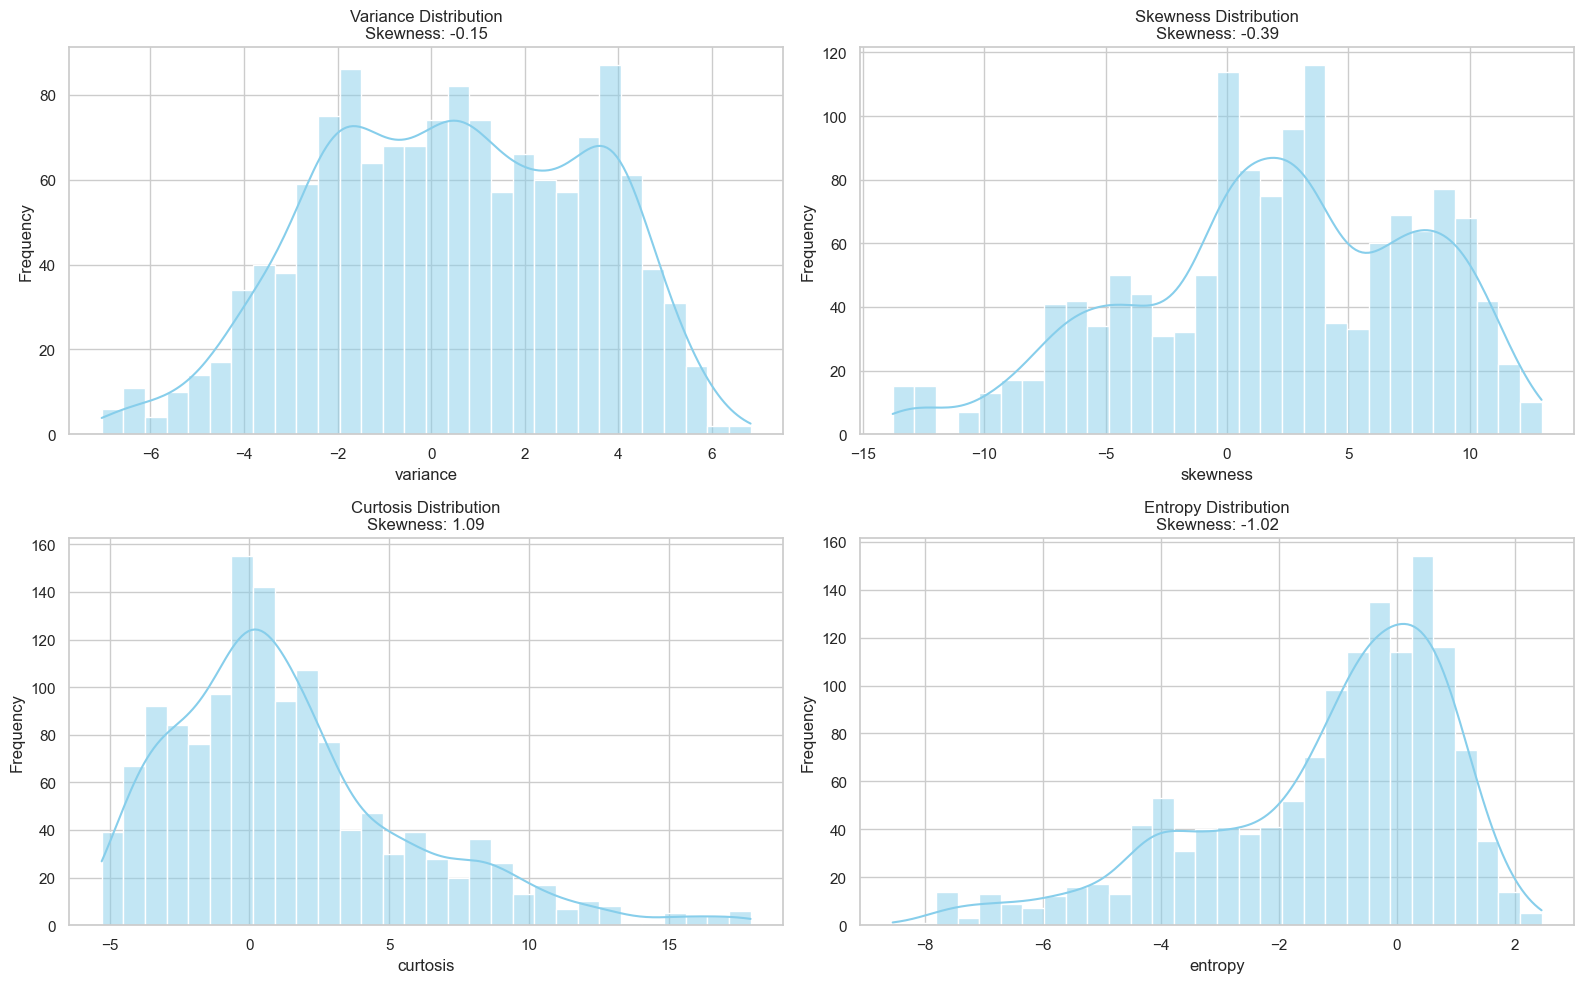

In [91]:
# Checking Continuous Features for Skewedness

sns.set(style='whitegrid')

# Plot distributions and display skewness values
features = ['variance', 'skewness', 'curtosis', 'entropy']
plt.figure(figsize=(16, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data[feature], kde=True, color='skyblue', bins=30)
    skew_val = data[feature].skew()
    plt.title(f'{feature.capitalize()} Distribution\nSkewness: {skew_val:.2f}')
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

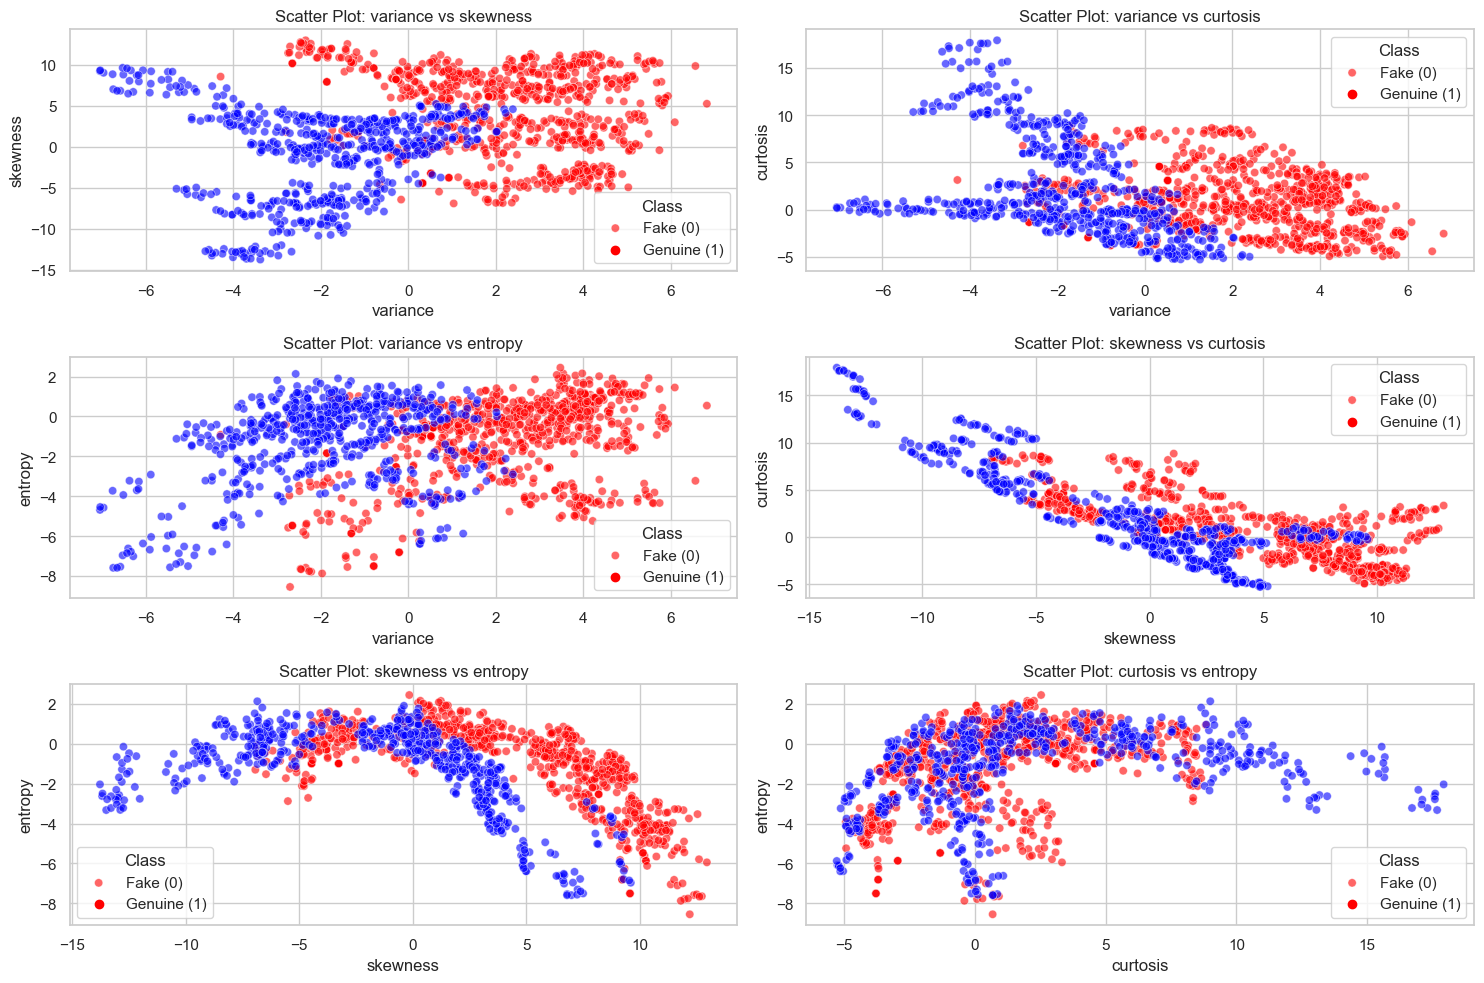

In [92]:
#  Evaluating Feature Importance
# Define feature pairs for scatter plots
feature_pairs = list(combinations(['variance', 'skewness', 'curtosis', 'entropy'], 2))

# Plot scatter plots for each pair of features
plt.figure(figsize=(15, 10))
for i, (feature_x, feature_y) in enumerate(feature_pairs, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(data=data, x=feature_x, y=feature_y, hue='auth', palette={0: "red", 1: "blue"}, alpha=0.6)
    plt.title(f'Scatter Plot: {feature_x} vs {feature_y}')
    plt.legend(title="Class", labels=["Fake (0)", "Genuine (1)"])

plt.tight_layout()
plt.show()

Preaparing Data 

In [93]:
    # Normalizing Numerical Features
    # Separate features and target
    X = data.drop(columns=['auth'])  # Numerical features
    y = data['auth']  # Target variable

    # Apply Min-Max Scaling
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Convert scaled data back into a DataFrame
    data_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    data_scaled['auth'] = y  # Add target column back

    # Display first few rows of scaled data
    print(data_scaled.head())

   variance  skewness  curtosis   entropy  auth
0  0.769004  0.839643  0.106783  0.736628     0
1  0.835659  0.820982  0.121804  0.644326     0
2  0.786629  0.416648  0.310608  0.786951     0
3  0.757105  0.871699  0.054921  0.450440     0
4  0.531578  0.348662  0.424662  0.687362     0


In [94]:
# Shuffle and Split Data
# Split features and target variable
X = data_scaled.drop(columns=['auth'])  # Features
y = data_scaled['auth']  # Target variable (0: Fake, 1: Genuine)

# Split data into training and testing sets (40% test, 60% train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 823 samples.
Testing set has 549 samples.


We have chosen the following supervised learning models to build the trained models:

Support Vector Machines (SVM)
Gradient Boosting, an ensemble method
K-Nearest Neighbors (KNeighbors)

In [95]:
import time
from sklearn.metrics import fbeta_score, accuracy_score, confusion_matrix

# Function to train and evaluate a model
def train_predict(learner, X_train, y_train, X_test, y_test): 
    """
    Trains and evaluates a machine learning model.

    Parameters:
       - learner: The learning algorithm (e.g., DecisionTree, SVM, etc.)
       - X_train: Training features
       - y_train: Training labels
       - X_test: Testing features
       - y_test: Testing labels

    Returns:
       - results: Dictionary containing accuracy (%), F2-score, prediction time, and confusion matrix.
    """

    results = {}
    beta = 2  # F2 score: favors recall

    # Train the model on the full training set
    start = time.time()
    learner.fit(X_train, y_train)
    end = time.time()
    results['train_time'] = end - start

    # Make predictions
    start = time.time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time.time()
    results['pred_time'] = end - start

    # Accuracy in percentage
    results['acc_train'] = accuracy_score(y_train, predictions_train) * 100
    results['acc_test'] = accuracy_score(y_test, predictions_test) * 100

    # F2 scores
    results['f_train'] = fbeta_score(y_train, predictions_train, beta=beta)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=beta)

    # Confusion matrix
    results['conf_mat'] = confusion_matrix(y_test, predictions_test)

    # Output summary
    print(f"{learner.__class__.__name__} trained on full dataset.")
    print(f"Training Accuracy: {results['acc_train']:.2f}%")
    print(f"Testing Accuracy: {results['acc_test']:.2f}%")
    print(f"Training F{beta} Score: {results['f_train']:.3f}")
    print(f"Testing F{beta} Score: {results['f_test']:.3f}")

    return results



Support Vector Machines (SVM)

In [96]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier  # You may need to install XGBoost: pip install xgboost


In [97]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [98]:
#Train and Evaluate the Models
# Initialize models
svm_model = SVC(kernel='rbf', C=10, random_state=5)
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=5)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=5)

# You may choose the sample size (e.g., use full training set)
sample_size = X_train.shape[0]

# Train and evaluate SVM
print("\n--- SVM ---")
svm_results = train_predict(svm_model, X_train, y_train, X_test, y_test)

# Train and evaluate Gradient Boosting
print("\n--- Gradient Boosting ---")
gb_results = train_predict(gb_model, X_train, y_train, X_test, y_test)

# Train and evaluate XGBoost
print("\n--- XGBoost ---")
xgb_results = train_predict(xgb_model, X_train, y_train, X_test, y_test)



--- SVM ---
SVC trained on full dataset.
Training Accuracy: 100.00%
Testing Accuracy: 100.00%
Training F2 Score: 1.000
Testing F2 Score: 1.000

--- Gradient Boosting ---
GradientBoostingClassifier trained on full dataset.
Training Accuracy: 100.00%
Testing Accuracy: 99.45%
Training F2 Score: 1.000
Testing F2 Score: 0.995

--- XGBoost ---
XGBClassifier trained on full dataset.
Training Accuracy: 100.00%
Testing Accuracy: 98.36%
Training F2 Score: 1.000
Testing F2 Score: 0.979


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:42:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [99]:
print("\n=== Model Comparison ===")
models = {
    "SVM": svm_results,
    "Gradient Boosting": gb_results,
    "XGBoost": xgb_results
}

for name, res in models.items():
    print(f"\n{name}")
    print(f"Accuracy (Test): {res['acc_test']:.3f}")
    print(f"F2-Score (Test): {res['f_test']:.3f}")
    print(f"Prediction Time: {res['pred_time']:.4f}s")
    print("Confusion Matrix:")
    print(res['conf_mat'])



=== Model Comparison ===

SVM
Accuracy (Test): 100.000
F2-Score (Test): 1.000
Prediction Time: 0.0072s
Confusion Matrix:
[[295   0]
 [  0 254]]

Gradient Boosting
Accuracy (Test): 99.454
F2-Score (Test): 0.995
Prediction Time: 0.0158s
Confusion Matrix:
[[293   2]
 [  1 253]]

XGBoost
Accuracy (Test): 98.361
F2-Score (Test): 0.979
Prediction Time: 0.0060s
Confusion Matrix:
[[292   3]
 [  6 248]]


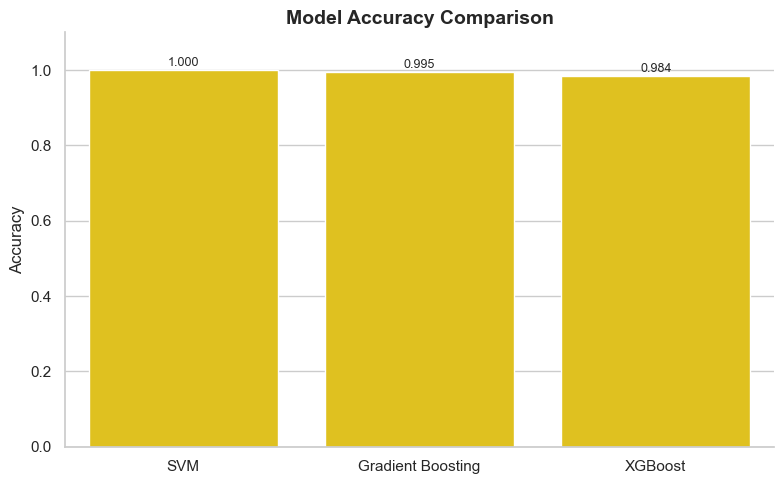

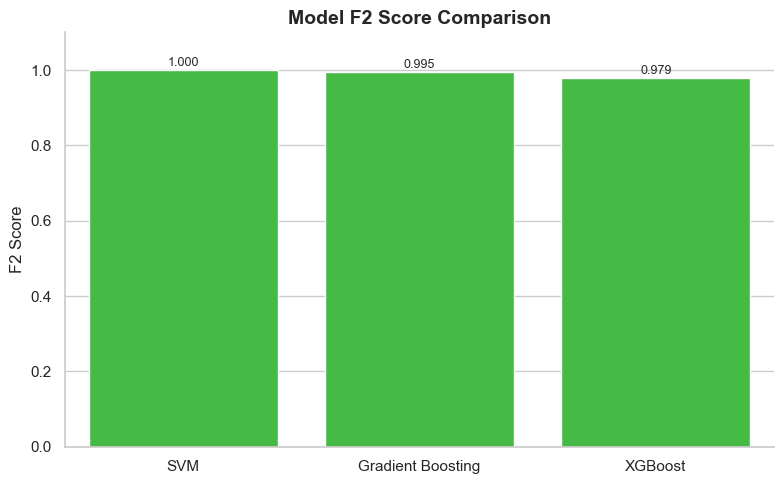

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use a clean and modern seaborn theme
sns.set_theme(style="whitegrid")

# Sample model data
models = {
    'SVM': {'acc_test': 1.000, 'f_test': 1.000},
    'Gradient Boosting': {'acc_test': 0.995, 'f_test': 0.995},
    'XGBoost': {'acc_test': 0.984, 'f_test': 0.979}
}

model_names = list(models.keys())
accuracies = [models[m]['acc_test'] for m in model_names]
f2_scores = [models[m]['f_test'] for m in model_names]

# Custom colors
colors = {
    "Accuracy": "#FFD700",       # Yellow
    "F2 Score": "#FF6347"        # Red
}

x = np.arange(len(model_names))

# --- Accuracy Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette=[colors["Accuracy"]]*len(model_names))
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
sns.despine()
plt.tight_layout()
plt.show()

# --- F2 Score Plot ---

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=f2_scores, palette=["#32CD32"] * len(model_names))  # LimeGreen
plt.title('Model F2 Score Comparison', fontsize=14, fontweight='bold')
plt.ylabel('F2 Score', fontsize=12)
plt.ylim(0, 1.1)

# Add bar annotations
for i, v in enumerate(f2_scores):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

sns.despine()
plt.tight_layout()
plt.show()



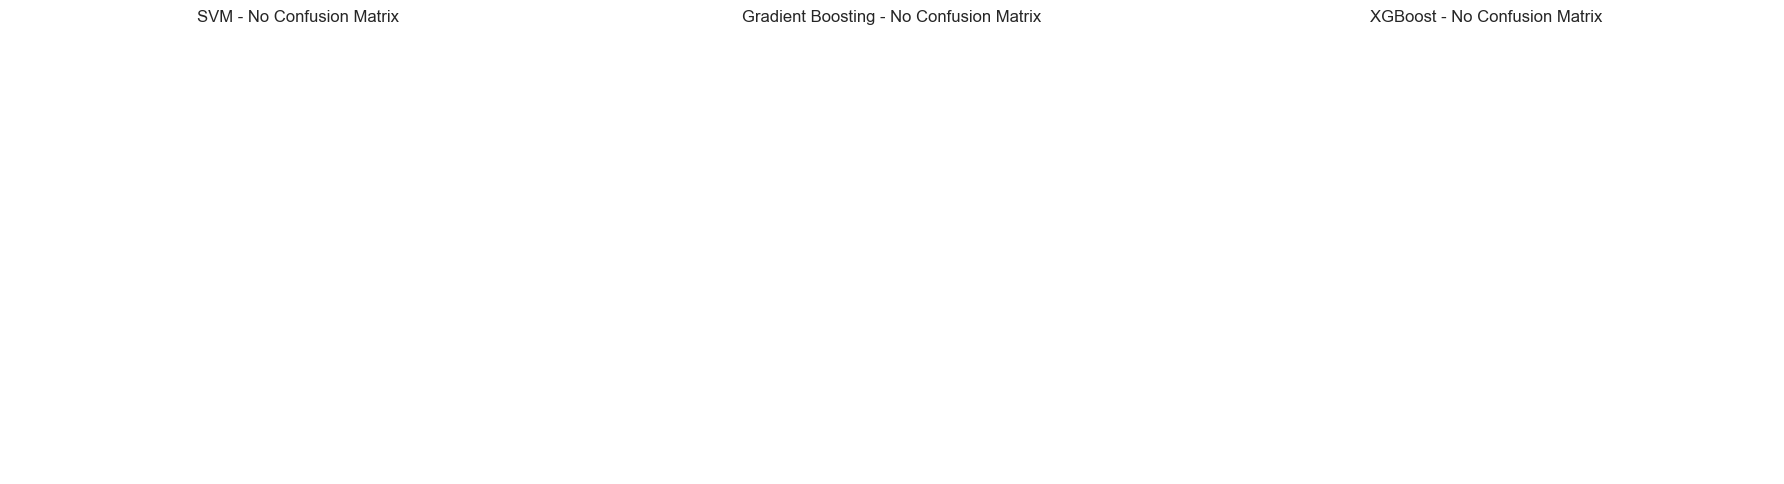

In [107]:


# Set up the subplot grid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loop through the models and plot each confusion matrix
for idx, (name, res) in enumerate(models.items()):
    conf_mat = res.get('conf_mat')  # Safely get the confusion matrix
    if conf_mat is None:
        axes[idx].set_title(f"{name} - No Confusion Matrix")
        axes[idx].axis('off')
        continue

    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f"{name} - Confusion Matrix", fontsize=13, fontweight='bold')
    axes[idx].set_xlabel("Predicted Labels", fontsize=11)
    axes[idx].set_ylabel("True Labels", fontsize=11)

# Layout adjustment
plt.tight_layout()
plt.show()


In [108]:
#Improved XGBoost Code with GridSearchCV

# Define the model
xgb = XGBClassifier(random_state=5, use_label_encoder=False, eval_metric='logloss')

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='f1',  # Or 'f1_weighted' / 'f1_macro'
                           cv=3,
                           n_jobs=-1,
                           verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best estimator
best_xgb = grid_search.best_estimator_

# Evaluate on test set
from sklearn.metrics import accuracy_score, fbeta_score, confusion_matrix

preds = best_xgb.predict(X_test)

print("\n--- Tuned XGBoost ---")
print("Best Params:", grid_search.best_params_)
print("Accuracy (Test): {:.3f}".format(accuracy_score(y_test, preds)))
print("F2-Score (Test): {:.3f}".format(fbeta_score(y_test, preds, beta=2)))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))


Fitting 3 folds for each of 108 candidates, totalling 324 fits

--- Tuned XGBoost ---
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Accuracy (Test): 0.993
F2-Score (Test): 0.994
Confusion Matrix:
 [[292   3]
 [  1 253]]


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:44:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


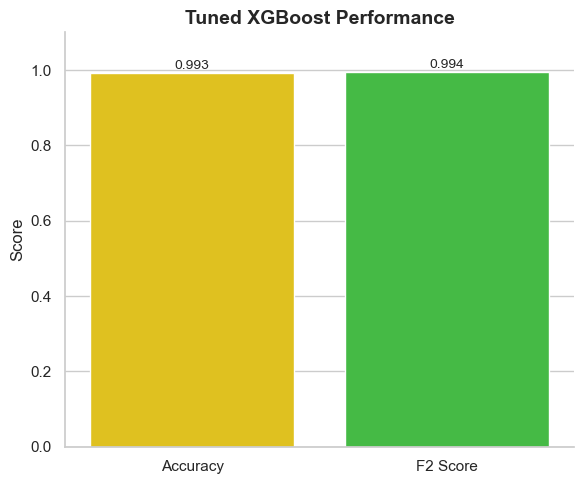

In [104]:

# Set style
sns.set_theme(style="whitegrid")

# Example performance metrics for tuned XGBoost
xgb_metrics = {
    'Accuracy': accuracy_score(y_test, preds),
    'F2 Score': fbeta_score(y_test, preds, beta=2)
}

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(x=list(xgb_metrics.keys()), y=list(xgb_metrics.values()), palette=["#FFD700", "#32CD32"])  # Yellow and Green

# Annotate
for i, (label, score) in enumerate(xgb_metrics.items()):
    plt.text(i, score + 0.01, f"{score:.3f}", ha='center', fontsize=10)

plt.title('Tuned XGBoost Performance', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1.1)
sns.despine()
plt.tight_layout()
plt.show()


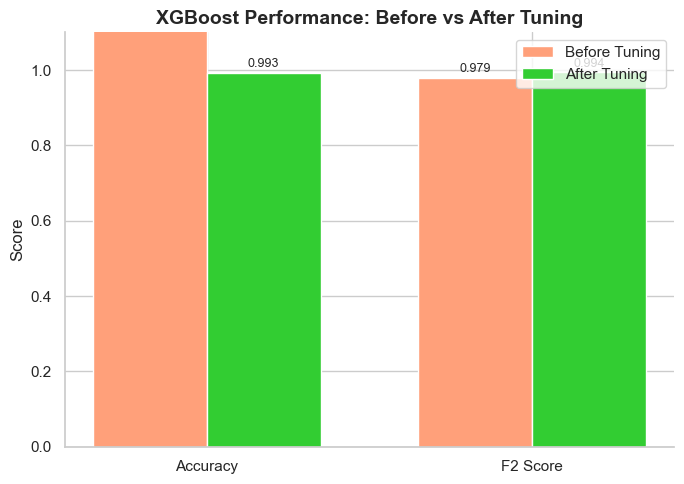

In [57]:


# Set theme
sns.set_theme(style="whitegrid")

# Performance metrics
xgb_before = {
    'Accuracy': xgb_results['acc_test'],
    'F2 Score': xgb_results['f_test']
}

xgb_after = {
    'Accuracy': accuracy_score(y_test, preds),
    'F2 Score': fbeta_score(y_test, preds, beta=2)
}

# Data setup
metrics = list(xgb_before.keys())
x = np.arange(len(metrics))
width = 0.35

# Bar plot
fig, ax = plt.subplots(figsize=(7, 5))
bars1 = ax.bar(x - width/2, xgb_before.values(), width, label='Before Tuning', color='#FFA07A')  # Light salmon
bars2 = ax.bar(x + width/2, xgb_after.values(), width, label='After Tuning', color='#32CD32')    # Lime green

# Annotations
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 4), textcoords="offset points", ha='center', fontsize=9)

# Labels and title
ax.set_ylabel('Score', fontsize=12)
ax.set_title('XGBoost Performance: Before vs After Tuning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()

sns.despine()
plt.tight_layout()
plt.show()


Featue Importance



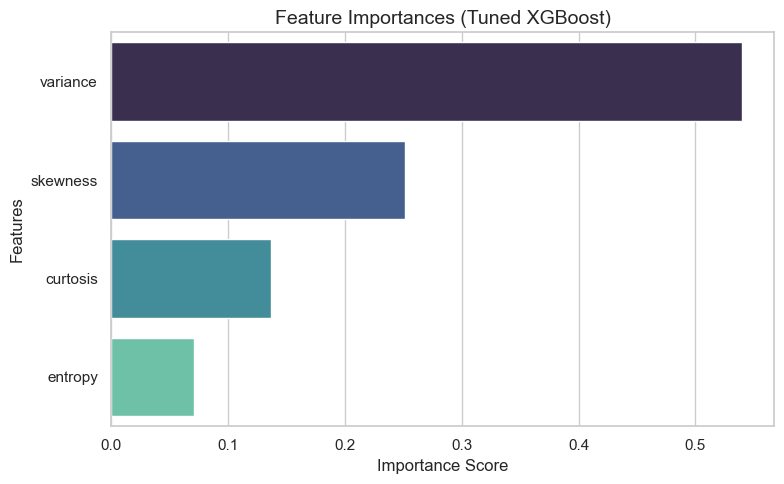

In [58]:


# Get feature importances from the best estimator
importances = best_xgb.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importances
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=importances[indices], y=feature_names[indices], palette="mako")
plt.title('Feature Importances (Tuned XGBoost)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


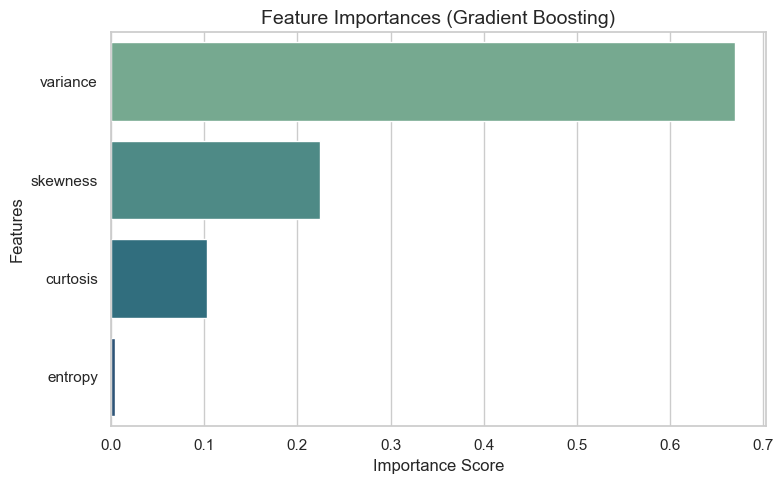

In [59]:


# Get feature importances from the trained model
importances = gb_model.feature_importances_

# Feature names
feature_names = X_train.columns

# Sort importances
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=importances[indices], y=feature_names[indices], palette="crest")
plt.title('Feature Importances (Gradient Boosting)', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


Predict 3 Random Samples with All Models

In [69]:
def compare_model_predictions(X_test, y_test, models_dict, label_map={0: "Fake", 1: "Genuine"}, sample_size=3, random_seed=42, custom_log_weights=None):
    """
    Compare predictions of multiple models (including custom logistic regression) on random samples from the test set.

    Parameters:
    - X_test: Test features (DataFrame)
    - y_test: Test labels (Series)
    - models_dict: Dictionary of models { "ModelName": model_object or "CustomLogistic" }
    - label_map: Dictionary to map 0/1 to labels
    - sample_size: Number of samples to test
    - random_seed: Seed for reproducibility
    - custom_log_weights: Weights array for the custom logistic regression model

    Prints:
    - Prediction comparison table
    """
    
    # Pick random samples
    np.random.seed(random_seed)
    random_indices = np.random.choice(X_test.index, size=sample_size, replace=False)
    X_sample = X_test.loc[random_indices]
    y_true = y_test.loc[random_indices].astype(int)

    # Base results DataFrame
    results_df = X_sample.copy()
    results_df['Actual'] = y_true.map(label_map)

    # Iterate over models
    for name, model in models_dict.items():
        if name == "CustomLogistic":
            if custom_log_weights is None:
                raise ValueError("Custom logistic weights must be provided.")
            preds = predict(X_sample, custom_log_weights).flatten()
        else:
            preds = model.predict(X_sample)

        preds_series = pd.Series(preds, index=X_sample.index, dtype=int)
        results_df[f'{name}_Pred'] = preds_series.map(label_map)
        results_df[f'{name}_Correct'] = results_df[f'{name}_Pred'] == results_df['Actual']

    # Display selected columns
    display_cols = ['Actual']
    for name in models_dict:
        display_cols.extend([f'{name}_Pred', f'{name}_Correct'])

    print(f"\n=== Model Predictions on {sample_size} Random Banknotes ===")
    print(results_df[display_cols].to_string(index=False))


In [70]:
# Dictionary of models
models = {
    "SVM": svm_model,
    "GB": gb_model,
    "XGB": best_xgb
}

# Call the function
compare_model_predictions(X_test, y_test, models)



=== Model Predictions on 3 Random Banknotes ===
 Actual SVM_Pred  SVM_Correct GB_Pred  GB_Correct XGB_Pred  XGB_Correct
   Fake     Fake         True    Fake        True     Fake         True
Genuine  Genuine         True Genuine        True  Genuine         True
   Fake     Fake         True    Fake        True     Fake         True


Logistic Regression

In [114]:


# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost function (for reference/logging)
def compute_cost(X, y, weights):
    m = len(y)
    h = sigmoid(np.dot(X, weights))
    epsilon = 1e-5  # avoid log(0)
    cost = (-y * np.log(h + epsilon) - (1 - y) * np.log(1 - h + epsilon)).mean()
    return cost

# Logistic regression training function
def logistic_regression(X, y, lr=0.1, epochs=1000):
    X = np.insert(X.values, 0, 1, axis=1)  # Add bias term
    y = y.values.reshape(-1, 1)
    weights = np.zeros((X.shape[1], 1))

    for i in range(epochs):
        z = np.dot(X, weights)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        weights -= lr * gradient

        if i % 100 == 0:
            cost = compute_cost(X, y, weights)
            print(f"Epoch {i} | Cost: {cost:.4f}")

    return weights

# Prediction function
def predict(X, weights):
    X = np.insert(X.values, 0, 1, axis=1)
    probs = sigmoid(np.dot(X, weights))
    return (probs >= 0.5).astype(int)

# Custom wrapper for training and evaluating
def train_predict_custom_logistic(X_train, y_train, X_test, y_test):
    print("Training custom Logistic Regression ")
    weights = logistic_regression(X_train, y_train, lr=0.1, epochs=1000)
    
    # Predict on train and test
    y_train_pred = predict(X_train, weights)
    y_test_pred = predict(X_test, weights)

    # Evaluation
    beta = 2
    results = {
        'acc_train': accuracy_score(y_train, y_train_pred) * 100,
        'acc_test': accuracy_score(y_test, y_test_pred) * 100,
        'f_train': fbeta_score(y_train, y_train_pred, beta=beta),
        'f_test': fbeta_score(y_test, y_test_pred, beta=beta),
        'conf_mat': confusion_matrix(y_test, y_test_pred)
    }

    # Output results
    print("Custom Logistic Regression Results:")
    print(f"Training Accuracy: {results['acc_train']:.2f}%")
    print(f"Testing Accuracy: {results['acc_test']:.2f}%")
    print(f"Training F{beta} Score: {results['f_train']:.3f}")
    print(f"Testing F{beta} Score: {results['f_test']:.3f}")
    print("Confusion Matrix:\n", results['conf_mat'])

    return results

#  Run the custom model
results_custom_logreg = train_predict_custom_logistic(X_train, y_train, X_test, y_test)


Training custom Logistic Regression 
Epoch 0 | Cost: 0.6905
Epoch 100 | Cost: 0.6213
Epoch 200 | Cost: 0.5811
Epoch 300 | Cost: 0.5490
Epoch 400 | Cost: 0.5226
Epoch 500 | Cost: 0.5004
Epoch 600 | Cost: 0.4814
Epoch 700 | Cost: 0.4648
Epoch 800 | Cost: 0.4501
Epoch 900 | Cost: 0.4370
Custom Logistic Regression Results:
Training Accuracy: 86.51%
Testing Accuracy: 84.34%
Training F2 Score: 0.769
Testing F2 Score: 0.759
Confusion Matrix:
 [[278  17]
 [ 69 185]]


In [115]:


# Define models for prediction comparison
models = {
    
    "CustomLogistic": None  # Placeholder
}

# Compare predictions from all models
compare_model_predictions(X_test, y_test, models_dict=models, custom_log_weights=weights)



=== Model Predictions on 3 Random Banknotes ===
 Actual CustomLogistic_Pred  CustomLogistic_Correct
   Fake                Fake                    True
Genuine                Fake                   False
   Fake                Fake                    True


Epoch 0 | Cost: 0.6905
Epoch 100 | Cost: 0.6213
Epoch 200 | Cost: 0.5811
Epoch 300 | Cost: 0.5490
Epoch 400 | Cost: 0.5226
Epoch 500 | Cost: 0.5004
Epoch 600 | Cost: 0.4814
Epoch 700 | Cost: 0.4648
Epoch 800 | Cost: 0.4501
Epoch 900 | Cost: 0.4370


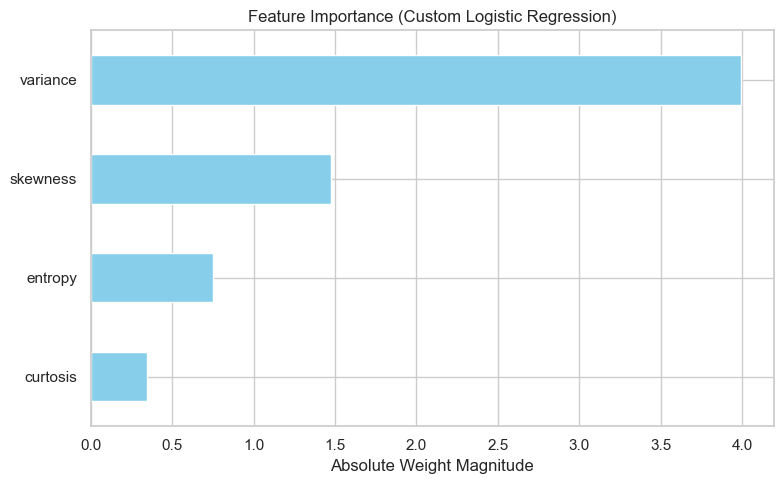

In [116]:
import matplotlib.pyplot as plt

def plot_logistic_feature_importance(weights, feature_names):
    # Remove the bias term (first weight)
    weights_no_bias = weights[1:].flatten()  # flatten to 1D
    feature_importance = pd.Series(np.abs(weights_no_bias), index=feature_names)

    # Sort by importance
    feature_importance = feature_importance.sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(8, 5))
    feature_importance.plot(kind='barh', color='skyblue')
    plt.title('Feature Importance (Custom Logistic Regression)')
    plt.xlabel('Absolute Weight Magnitude')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Example usage after training:
weights = logistic_regression(X_train, y_train)  # retrain if needed
plot_logistic_feature_importance(weights, X_train.columns)
